# Transer Learing with Convolutional Neural Networks

Now that we have some experience with CNNs let us try some transfer learning. Transfer learning is a method of reusing a model or knowledge for another related task. Transfer learning can be considered as spanning four scenarios:
- The feature spaces of source and target domains are different from each other
- The marginal probabilities or source and target domains are different
- The label spaces of the source and target domains are different in this scenario
- Conditional probabilities are different in the source and target domains.

In this excercise we follow the examples laid out by Dipanjan Sarkar, Raghav Bali and Tamoghna Ghosh in thier book 'Transfer Learning with Python' begining with an example of classification on the kaggle [Dogs vs Cats](https://www.kaggle.com/c/dogs-vs-cats/data) data set.

In [11]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

%matplotlib inline

In [2]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [3]:
from heardingcats import heard
heard()

Cat datasets: (1500,) (500,) (500,)
Dog datasets: (1500,) (500,) (500,)


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


## Dataset and Keras Configuration

In [4]:
IMG_DIM = (150, 150)

train_files = glob.glob('training_data/*')
train_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in train_files]
train_imgs = np.array(train_imgs, dtype='float32')
train_labels = [fn.split('/')[1].split('.')[0].strip() for fn in train_files]

validation_files = glob.glob('validation_data/*')
validation_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in validation_files]
validation_imgs = np.array(validation_imgs, dtype='float32')
validation_labels = [fn.split('/')[1].split('.')[0].strip() for fn in validation_files]

print('Train dataset shape:', train_imgs.shape, 
      '\tValidation dataset shape:', validation_imgs.shape)

Train dataset shape: (3000, 150, 150, 3) 	Validation dataset shape: (2850, 150, 150, 3)


overall (3000, 150, 150, 3)
(150, 150, 3)


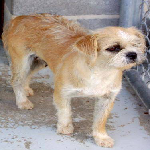

In [5]:
print("overall",train_imgs.shape)
print(train_imgs[0].shape)
array_to_img(train_imgs[0])

We scale each image with pixel values between (0, 255) to values between (0, 1) in order to improve performance:

In [6]:
train_imgs_scaled = train_imgs / 255.
validation_imgs_scaled = validation_imgs / 255

first we set up some basic configuration parameters and also encode our text class labels into numeric values (otherwise, Keras will throw an error):

In [7]:
batch_size = 30
num_classes = 2
epochs = 30
input_shape = (150, 150, 3)
# encode text category labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train_labels)
train_labels_enc = le.transform(train_labels)
validation_labels_enc = le.transform(validation_labels)
print(train_labels[1495:1505], train_labels_enc[1495:1505])

['dog', 'dog', 'cat', 'cat', 'cat', 'dog', 'cat', 'cat', 'dog', 'cat'] [1 1 0 0 0 1 0 0 1 0]


### Defining a simple Convolutional Neural Net

This basic CNN model has three convolutional layers, coupled with max pooling for auto-extraction of features from the images and also downsampling the output convolution feature maps.

After extracting some feature maps, one dense layer is used along with an output layer with a sigmoid function for classification. Since we are doing binary classification, a binary_crossentropy loss function will suffice. The RMSprop optimizer is used.

In [8]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.models import Sequential
from keras import optimizers

model = Sequential()

model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', 
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(),
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        9280      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 36992)             0         
__________

The flatten layer is used to flatten out 128 of the 17 x 17 feature maps that we get as output from the third convolution layer. This is fed to our dense layers to get the final prediction of whether the image should be a dog (1) or a cat (0). All of this is part of the model training process, so let's train our model using the following snippet which leverages the fit(...) function. The following terminology is very important with regard to training our model:
- The batch_size indicates the total number of images passed to the model per iteration
- The weights of the units in layers are updated after each iteration
- The total number of iterations is always equal to the total number of training samples divided by the batch_size
- An epoch is when the complete dataset has passed through the network once, that is, all the iterations are completed based on data batches

In [9]:
history = model.fit(x=train_imgs_scaled, y=train_labels_enc,
                    validation_data=(validation_imgs_scaled, validation_labels_enc),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1)

Train on 3000 samples, validate on 2850 samples
Epoch 1/30
3000/3000 [==============================] - 11s 4ms/step - loss: 0.8663 - acc: 0.5790 - val_loss: 0.6648 - val_acc: 0.6123
Epoch 2/30
3000/3000 [==============================] - 10s 3ms/step - loss: 0.6289 - acc: 0.6633 - val_loss: 0.6085 - val_acc: 0.6818
Epoch 3/30
3000/3000 [==============================] - 10s 3ms/step - loss: 0.5499 - acc: 0.7227 - val_loss: 0.9491 - val_acc: 0.5632
Epoch 4/30
3000/3000 [==============================] - 10s 3ms/step - loss: 0.4920 - acc: 0.7703 - val_loss: 0.6632 - val_acc: 0.6933
Epoch 5/30
3000/3000 [==============================] - 10s 3ms/step - loss: 0.4160 - acc: 0.8080 - val_loss: 0.5847 - val_acc: 0.7225
Epoch 6/30
3000/3000 [==============================] - 10s 3ms/step - loss: 0.3345 - acc: 0.8493 - val_loss: 0.6202 - val_acc: 0.7207
Epoch 7/30
3000/3000 [==============================] - 10s 3ms/step - loss: 0.2463 - acc: 0.8890 - val_loss: 0.7032 - val_acc: 0.7246
Epoch 8

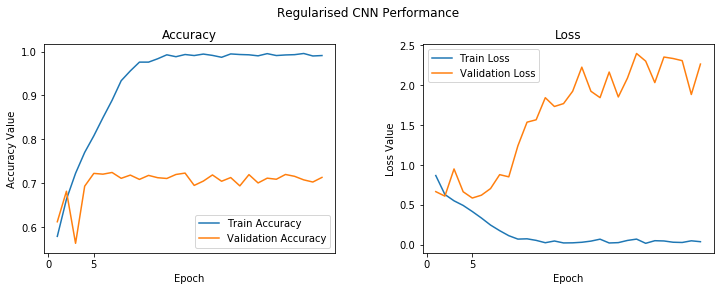

In [12]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Regularised CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,epochs+1))
ax1.plot(epoch_list, history.history['acc'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 10, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 10, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

Plotting the model accuracy and errors as above can give a better perspective on whether or not the model is over fitting.

### Regularisation

Our first attempt to add some knowledge of the model will be throught the use of regularisation. It could be that majority of training images have white dogs and black cats and therefore the model is giving too much preference to this one feature. Regularisation adds some knowledge of the problem, in that it forces the model to give higher creedence to more subtle features. 

To do this we improve our base CNN model by adding in one more convolution layer, another dense hidden layer. Besides this, we will add dropout of 0.3 after each hidden dense layer to enable regularization.

Dropout randomly masks the outputs of a fraction of units from a layer by setting their output to zero (in our case, it is 30% of the units in our dense layers):

In [13]:
model = Sequential()
# convolutional and pooling layers
model.add(Conv2D(16, kernel_size=(3, 3), activation='relu',
                input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(),
              metrics=['accuracy'])

In [14]:
history = model.fit(x=train_imgs_scaled, y=train_labels_enc,
                    validation_data=(validation_imgs_scaled,
                                     validation_labels_enc),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1)

Train on 3000 samples, validate on 2850 samples
Epoch 1/30
3000/3000 [==============================] - 9s 3ms/step - loss: 0.7134 - acc: 0.5400 - val_loss: 0.6666 - val_acc: 0.5772
Epoch 2/30
3000/3000 [==============================] - 9s 3ms/step - loss: 0.6543 - acc: 0.6197 - val_loss: 0.6113 - val_acc: 0.6582
Epoch 3/30
3000/3000 [==============================] - 9s 3ms/step - loss: 0.6194 - acc: 0.6660 - val_loss: 0.6216 - val_acc: 0.6333
Epoch 4/30
3000/3000 [==============================] - 9s 3ms/step - loss: 0.5777 - acc: 0.7003 - val_loss: 0.5869 - val_acc: 0.6968
Epoch 5/30
3000/3000 [==============================] - 9s 3ms/step - loss: 0.5429 - acc: 0.7303 - val_loss: 0.7922 - val_acc: 0.6768
Epoch 6/30
3000/3000 [==============================] - 9s 3ms/step - loss: 0.4977 - acc: 0.7563 - val_loss: 0.5748 - val_acc: 0.6933
Epoch 7/30
3000/3000 [==============================] - 9s 3ms/step - loss: 0.4492 - acc: 0.7907 - val_loss: 0.5592 - val_acc: 0.7382
Epoch 8/30
300

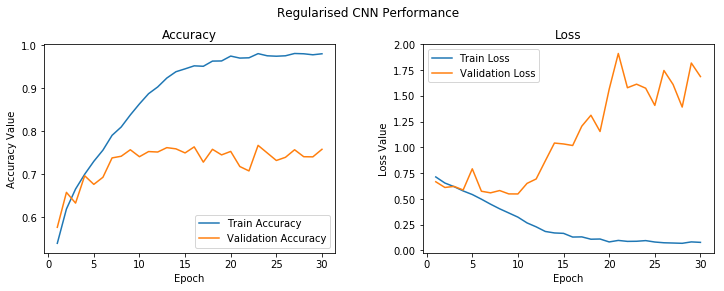

In [16]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Regularised CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,31))
ax1.plot(epoch_list, history.history['acc'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 31, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 31, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

You can clearly see from the preceding outputs that we still end up overfitting the model, though it takes slightly longer and we also get a slightly better validation accuracy of around 78%, which is decent but not amazing.

In [17]:
model.save('cats_dogs_regularised_cnn.h5')

## Image Augmentation

Here we leverage an image augmentation strategy to augment our existing training data with images that are slight variations of the existing images.

The idea behind image augmentation is that we follow a set process of taking in existing images from our training dataset and applying some image transformation operations to them, such as rotation, shearing, translation, zooming, and so on, to produce new, altered versions of existing images. Due to these random transformations, we don't get the same images each time, and we will leverage Python generators to feed in these new images to our model during training.

The Keras framework has an excellent utility called ImageDataGenerator that can help us in doing all the preceding operations. Let's initialize two of the data generators for our training and validation datasets:

In [18]:
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3,
                                   rotation_range=50,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
val_datagen = ImageDataGenerator(rescale=1./255)

Let's see how some of these generated images might look so that you can understand them better. We will take two sample images from our training dataset to illustrate the same. The first image is an image of a cat:

Labels: ['cat', 'cat', 'cat', 'cat', 'cat']


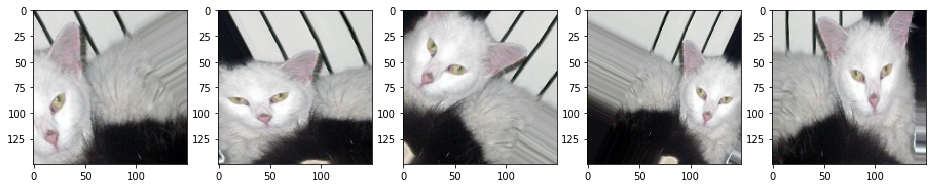

In [19]:
img_id = 2595
cat_generator = train_datagen.flow(train_imgs[img_id:img_id+1],
                                   train_labels[img_id:img_id+1],
                                   batch_size=1)
cat = [next(cat_generator) for i in range(0,5)]
fig, ax = plt.subplots(1,5, figsize=(16, 6))
print('Labels:', [item[1][0] for item in cat])
l = [ax[i].imshow(cat[i][0][0]) for i in range(0,5)]

In [20]:
train_generator = train_datagen.flow(train_imgs, train_labels_enc,
                                     batch_size=30)
val_generator = val_datagen.flow(validation_imgs,
                                 validation_labels_enc,
                                 batch_size=20)
input_shape = (150, 150, 3)

Now lets define our new model.

In [21]:
model = Sequential()
# convolution and pooling layers
model.add(Conv2D(16, kernel_size=(3, 3), activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['accuracy'])

We reduce the default learning rate by a factor of 10 here for our optimizer to prevent the model from getting stuck in a local minima or overfit, as we will be sending a lot of images with random transformations. To train the model, we need to slightly modify our approach now, since we are using data generators. We will leverage the fit_generator(...) function from Keras to train this model. The train_generator generates 30 images each time, so we will use the steps_per_epoch parameter and set it to 100 to train the model on 3,000 randomly generated images from the training data for each epoch. Our val_generator generates 20 images each time so we will set the validation_steps parameter to 50 to validate our model accuracy on all the 1,000 validation images (remember we are not augmenting our validation dataset):

In [22]:
history = model.fit_generator(train_generator,
                              steps_per_epoch=100, epochs=100,
                              validation_data=val_generator,
                              validation_steps=50, verbose=1)

Epoch 1/100
100/100 [==============================] - 16s 163ms/step - loss: 0.6923 - acc: 0.5253 - val_loss: 0.6861 - val_acc: 0.5050
Epoch 2/100
100/100 [==============================] - 16s 158ms/step - loss: 0.6795 - acc: 0.5630 - val_loss: 0.7065 - val_acc: 0.5090
Epoch 3/100
100/100 [==============================] - 16s 159ms/step - loss: 0.6703 - acc: 0.5893 - val_loss: 0.6773 - val_acc: 0.5700
Epoch 4/100
100/100 [==============================] - 16s 162ms/step - loss: 0.6574 - acc: 0.6187 - val_loss: 0.6775 - val_acc: 0.5660
Epoch 5/100
100/100 [==============================] - 16s 157ms/step - loss: 0.6514 - acc: 0.6093 - val_loss: 0.6357 - val_acc: 0.6390
Epoch 6/100
100/100 [==============================] - 16s 157ms/step - loss: 0.6355 - acc: 0.6390 - val_loss: 0.6211 - val_acc: 0.6470
Epoch 7/100
100/100 [==============================] - 16s 160ms/step - loss: 0.6253 - acc: 0.6550 - val_loss: 0.6045 - val_acc: 0.6640
Epoch 8/100
100/100 [===========================

Epoch 61/100
100/100 [==============================] - 16s 159ms/step - loss: 0.4278 - acc: 0.7987 - val_loss: 0.5046 - val_acc: 0.7770
Epoch 62/100
100/100 [==============================] - 16s 158ms/step - loss: 0.4382 - acc: 0.7910 - val_loss: 0.4706 - val_acc: 0.7890
Epoch 63/100
100/100 [==============================] - 16s 159ms/step - loss: 0.4358 - acc: 0.7983 - val_loss: 0.4797 - val_acc: 0.7900
Epoch 64/100
100/100 [==============================] - 16s 159ms/step - loss: 0.4414 - acc: 0.7927 - val_loss: 0.4571 - val_acc: 0.7880
Epoch 65/100
100/100 [==============================] - 16s 156ms/step - loss: 0.4248 - acc: 0.8017 - val_loss: 0.4737 - val_acc: 0.7930
Epoch 66/100
100/100 [==============================] - 16s 159ms/step - loss: 0.4322 - acc: 0.8057 - val_loss: 0.4334 - val_acc: 0.8020
Epoch 67/100
100/100 [==============================] - 16s 160ms/step - loss: 0.4231 - acc: 0.8037 - val_loss: 0.4474 - val_acc: 0.7910
Epoch 68/100
100/100 [===================

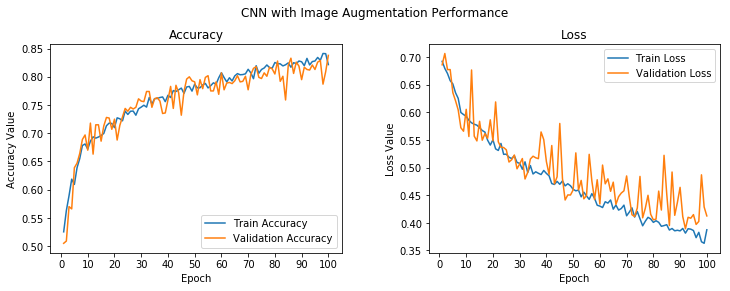

In [23]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('CNN with Image Augmentation Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,101))
ax1.plot(epoch_list, history.history['acc'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 101, 10))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 101, 10))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

While there are some spikes in the validation accuracy and loss, overall, we see that it is much closer to the training accuracy, with the loss indicating that we obtained a model that generalizes much better as compared to our previous models. 

In [24]:
model.save('cats_dogs_cnn_img_aug.h5')

## VGG16

In the hackathon we discussed the VGG-16 model in great length. An investigation into its properties can be found [here](http://www.robots.ox.ac.uk/~vgg/practicals/cnn/index.html) with a notebook to follow. VGG stands for the Visual Geometry Group at the University of Oxford, which specializes in building very deep convolutional networks for large-scale visual recognition. The model looks like this:

![""](https://www.researchgate.net/profile/Saikat_Roy9/publication/322787849/figure/fig1/AS:588338117488642@1517282146532/VGG16-Architecture-with-Softmax-layer-replaced-used-as-the-base-model-for-each-classifier.png)

You can clearly see that we have a total of 13 convolution layers using 3 x 3 convolution filters along with max pooling layers for downsampling and a total of two fully connected hidden layers of 4,096 units in each layer followed by a dense layer of 1,000 units, where each unit represents one of the image categories in the ImageNet database.

A pretrained model like the VGG-16 is an already trained model on a huge dataset (ImageNet) with a lot of diverse image categories. Considering this fact, the model should have learned a robust hierarchy of features, which are spatial, rotation, and translation invariant, as we have discussed before with regard to features learned by CNN models. Hence, the model, having learned a good representation of features for over a million images belonging to 1,000 different categories, can act as a good feature extractor for new images suitable for computer vision problems. These new images might never exist in the ImageNet dataset or might be of totally different categories, but the model should still be able to extract relevant features from these images.

In [26]:
from keras.applications import vgg16
from keras.models import Model
import keras
vgg = vgg16.VGG16(include_top=False, weights='imagenet',
                                        input_shape=input_shape)
output = vgg.layers[-1].output
output = keras.layers.Flatten()(output)
vgg_model = Model(vgg.input, output)
vgg_model.trainable = False
for layer in vgg_model.layers:
    layer.trainable = False
vgg_model.summary()


58892288/58889256 [==============================] - 3s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool

here all of the layers of the VGG-16 model are frozen because we don't want their weights to change during model training. The last activation feature map in the VGG-16 model (output from block5_pool) gives us the bottleneck features, which can then be flattened and fed to a fully connected deep neural network classifier.

(1, 4, 4, 512)


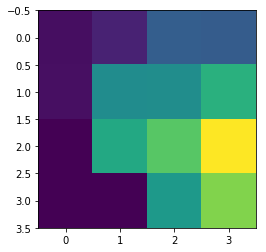

In [28]:
bottleneck_feature_example = vgg.predict(train_imgs_scaled[0:1])
print(bottleneck_feature_example.shape)
plt.imshow(bottleneck_feature_example[0][:,:,0])

In [29]:
def get_bottleneck_features(model, input_imgs):
    
    features = model.predict(input_imgs, verbose=0)
    return features

In [30]:
train_features_vgg = get_bottleneck_features(vgg_model, train_imgs_scaled)
validation_features_vgg = get_bottleneck_features(vgg_model, validation_imgs_scaled)

print('Train Bottleneck Features:', train_features_vgg.shape, 
      '\tValidation Bottleneck Features:', validation_features_vgg.shape)

Train Bottleneck Features: (3000, 8192) 	Validation Bottleneck Features: (2850, 8192)


We flatten the bottleneck features in the `vgg_model` object to make them ready to be fed to our fully connected classifier. A way to save time in model training is to use this model and extract out all the features from our training and validation datasets and then feed them as inputs to our classifier. We extract the bottleneck features from our training and validation sets and build the model.

In [32]:
from keras.layers import InputLayer

input_shape = vgg_model.output_shape[1]

model = Sequential()
model.add(InputLayer(input_shape=(input_shape,)))
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 8192)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 513       
Total params: 4,457,985
Trainable params: 4,457,985
Non-trainable params: 0
_________________________________________________________________


In [33]:
history = model.fit(x=train_features_vgg, y=train_labels_enc,
                    validation_data=(validation_features_vgg, validation_labels_enc),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1)

Train on 3000 samples, validate on 2850 samples
Epoch 1/30
3000/3000 [==============================] - 1s 498us/step - loss: 0.4343 - acc: 0.7837 - val_loss: 0.3850 - val_acc: 0.8158
Epoch 2/30
3000/3000 [==============================] - 1s 385us/step - loss: 0.2918 - acc: 0.8750 - val_loss: 0.2931 - val_acc: 0.8726
Epoch 3/30
3000/3000 [==============================] - 1s 378us/step - loss: 0.2487 - acc: 0.8947 - val_loss: 0.2685 - val_acc: 0.8888
Epoch 4/30
3000/3000 [==============================] - 1s 374us/step - loss: 0.2075 - acc: 0.9140 - val_loss: 0.2718 - val_acc: 0.8881
Epoch 5/30
3000/3000 [==============================] - 1s 376us/step - loss: 0.1758 - acc: 0.9290 - val_loss: 0.2820 - val_acc: 0.8923
Epoch 6/30
3000/3000 [==============================] - 1s 361us/step - loss: 0.1556 - acc: 0.9380 - val_loss: 0.3473 - val_acc: 0.8712
Epoch 7/30
3000/3000 [==============================] - 1s 349us/step - loss: 0.1345 - acc: 0.9453 - val_loss: 0.3410 - val_acc: 0.8800


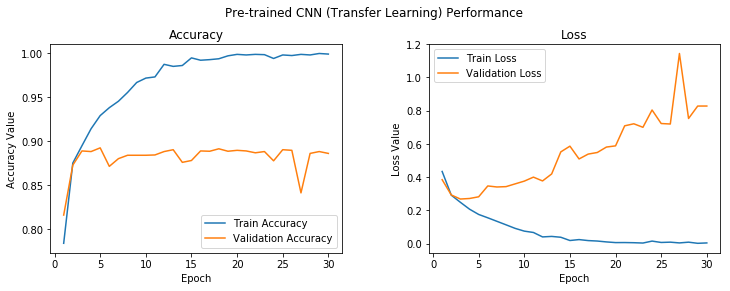

In [34]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Pre-trained CNN (Transfer Learning) Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,31))
ax1.plot(epoch_list, history.history['acc'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 31, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 31, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [35]:
model.save('cats_dogs_tlearn_basic_cnn.h5')

Even though this model is overfitting on the training data after only about 5 epochs overall, this seems to be the best model so far, with close to 90% validation accuracy without even using an image augmentation strategy so let's do that now.

In [36]:
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, rotation_range=50,
                                   width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
                                   horizontal_flip=True, fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(train_imgs, train_labels_enc, batch_size=30)
val_generator = val_datagen.flow(validation_imgs, validation_labels_enc, batch_size=20)

In [37]:
model = Sequential()
model.add(vgg_model)
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 8192)              14714688  
_________________________________________________________________
dense_12 (Dense)             (None, 512)               4194816   
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 513       
Total params: 19,172,673
Trainable params: 4,457,985
Non-trainable params: 14,714,688
________________________________________________________

In [38]:
history = model.fit_generator(train_generator, steps_per_epoch=100, epochs=100,
                              validation_data=val_generator, validation_steps=50, verbose=1)

Epoch 1/100
100/100 [==============================] - 40s 403ms/step - loss: 0.6549 - acc: 0.6043 - val_loss: 0.5037 - val_acc: 0.8040
Epoch 2/100
100/100 [==============================] - 37s 368ms/step - loss: 0.5672 - acc: 0.7110 - val_loss: 0.4164 - val_acc: 0.8410
Epoch 3/100
100/100 [==============================] - 37s 368ms/step - loss: 0.5060 - acc: 0.7487 - val_loss: 0.3714 - val_acc: 0.8460
Epoch 4/100
100/100 [==============================] - 37s 368ms/step - loss: 0.4694 - acc: 0.7757 - val_loss: 0.3469 - val_acc: 0.8520
Epoch 5/100
100/100 [==============================] - 37s 368ms/step - loss: 0.4577 - acc: 0.7800 - val_loss: 0.3271 - val_acc: 0.8650
Epoch 6/100
100/100 [==============================] - 37s 368ms/step - loss: 0.4437 - acc: 0.7940 - val_loss: 0.3479 - val_acc: 0.8570
Epoch 7/100
100/100 [==============================] - 37s 368ms/step - loss: 0.4248 - acc: 0.8007 - val_loss: 0.3315 - val_acc: 0.8600
Epoch 8/100
100/100 [===========================

Epoch 61/100
100/100 [==============================] - 37s 368ms/step - loss: 0.3147 - acc: 0.8670 - val_loss: 0.2451 - val_acc: 0.8930
Epoch 62/100
100/100 [==============================] - 37s 368ms/step - loss: 0.3019 - acc: 0.8733 - val_loss: 0.2525 - val_acc: 0.8920
Epoch 63/100
100/100 [==============================] - 37s 368ms/step - loss: 0.2974 - acc: 0.8677 - val_loss: 0.2429 - val_acc: 0.9010
Epoch 64/100
100/100 [==============================] - 37s 369ms/step - loss: 0.3001 - acc: 0.8693 - val_loss: 0.2557 - val_acc: 0.8940
Epoch 65/100
100/100 [==============================] - 37s 368ms/step - loss: 0.2980 - acc: 0.8690 - val_loss: 0.2619 - val_acc: 0.8870
Epoch 66/100
100/100 [==============================] - 37s 368ms/step - loss: 0.2882 - acc: 0.8753 - val_loss: 0.2666 - val_acc: 0.8860
Epoch 67/100
100/100 [==============================] - 37s 368ms/step - loss: 0.2952 - acc: 0.8730 - val_loss: 0.2557 - val_acc: 0.8920
Epoch 68/100
100/100 [===================

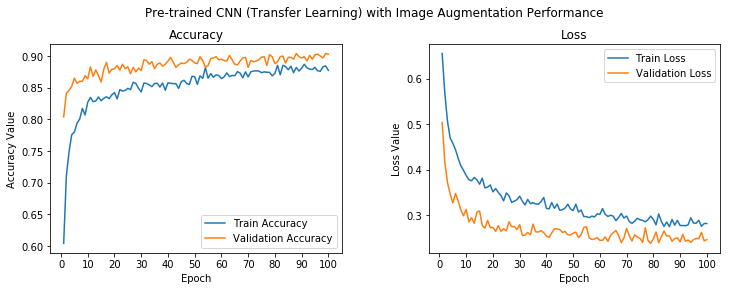

In [39]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Pre-trained CNN (Transfer Learning) with Image Augmentation Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,101))
ax1.plot(epoch_list, history.history['acc'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 101, 10))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 101, 10))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

We can see that our model has an overall validation accuracy of 85%, which is a slight improvement from our previous model, and also the train and validation accuracy are quite close to each other, indicating that the model is not overfitting.

In [40]:
model.save('cats_dogs_tlearn_img_aug_cnn.h5')